# About

- `Title:` "Learning relevant features of data with multi-scale tensor networks"
- `Main Author:` E. Miles Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1801.00315)
- `Publish Date:` 31-12-2017
- `Reviewed Date:` 07-06-2021

## Citation

```latex
@article{stoudenmire2018learning,
  title={Learning relevant features of data with multi-scale tensor networks},
  author={Stoudenmire, E Miles},
  journal={Quantum Science and Technology},
  volume={3},
  number={3},
  pages={034003},
  year={2018},
  publisher={IOP Publishing}
}
```

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import jax
import jax.numpy as jnp

In [3]:
from typing import Tuple, NamedTuple,\
                   Optional, Iterable,\
                   Callable, List,\
                   Dict, Any, Union

In [4]:
import os
import csv

In [5]:
import functools
import itertools

In [6]:
from sklearn import metrics

In [7]:
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

In [8]:
from timeit import default_timer as timer

# Utilities

The utilities below are used used in defferent parts of the main code.

In [9]:
def sliding_window(xs: List[Any], 
                   size: int, 
                   step: Optional[int]=2
                  ) -> List[List[Any]]:
    for i in range((len(xs)-size)//step + 1):
        yield xs[i*step:i*step+size]

In [10]:
print(*sliding_window(list(range(10)), size=3, step=2))

[0, 1, 2] [2, 3, 4] [4, 5, 6] [6, 7, 8]


## Powers of two

The code below is required to determine the appropriate size of the initial tree. The paper assumes that the numpber of leaves of the the tree is some power of two.

In [11]:
def is_power_of_two(n: int) -> bool:
    """
    Check if a given number is a power of two.
    """
    return (n & (n-1) == 0) and n != 0

In [12]:
def power_of_two(n: int) -> Tuple[int, int]:
    """
    Given a number, returns it's previous 
    and next of keen which are powers of two.
    """
    if is_power_of_two(n):
        return n, n
    count = 0    
    while n != 0:
        n >>= 1
        count += 1
    prec = 1 << (count-1)
    succ = 1 << count
    return prec, succ

quickly checking...

In [13]:
is_power_of_two(13), is_power_of_two(28*28), power_of_two(196)

(False, False, (128, 256))

## Some linear algebra

In [14]:
def ishermitian(A: jnp.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    """
    Check if the matrix is Hermitian.
    """
    return jnp.allclose(A, A.conj().T, rtol=rtol, atol=atol)

In [15]:
def ispd(A: jnp.ndarray) -> bool:
    """
    Check if a matrix is positive definite.
    """
    return jnp.all(jnp.linalg.eigvals(A) > 0)

In [16]:
def ispsd(A: jnp.ndarray) -> bool:
    """
    Check if a matrix is positive semidefinite.
    """
    return jnp.all(jnp.linalg.eigvals(A) >= 0)

In [17]:
def get_nearest_psd(A: jnp.ndarray) -> jnp.ndarray:
    """
    Get the nearest positive semidefinite matrix.
    The negative spectrum truncation is used.
    """
    C = (A + A.conj().T)/2
    p, U = jnp.linalg.eigh(C)
    p = p.at[jnp.where(p<0.0)].set(0)
    return  U @ (p * U.conj().T)

In [18]:
def get_nearest_pd(A: jnp.ndarray) -> jnp.ndarray:
    """
    Get the nearest positive definite matrix.
    The non-positive spectrum replacement is used.
    """
    C = (A + A.conj().T)/2
    p, U = jnp.linalg.eigh(C)
    p = p.at[jnp.where(p<=0.0)].set(1e-5)
    return  U @ (p * U.conj().T)

## Random matrices

In [19]:
def rand_unitary(dim: int) -> jnp.ndarray:
    """
    Random unitary matrix of dimention dim x dim
    http://home.lu.lv/~sd20008/papers/essays/Random%20unitary%20[paper].pdf
    """
    A = rand_mat(dim)
    Q,R = jnp.linalg.qr(A)
    r = jnp.diag(Q)
    L = jnp.diag(r/abs(r))
    return Q @ L

In [20]:
def rand_mat(dim1: int, dim2: Optional[int] = None) -> jnp.ndarray:
    """
    Genarate a random matrix of size (dim1, dim2).
    If no second dimention is provided, a square matrix
    of size (dim1, dim1) is returned.
    """
    if not dim2:
        dim2 = dim1
    key = jax.random.PRNGKey(31415)
    key, subkey = jax.random.split(key, 2)
    Re = jax.random.normal(key, shape=(dim1,dim2))
    Im = 1.j * jax.random.normal(subkey, shape=(dim1,dim2))
    return 2 * (Re + Im) - (1 + 1j)

In [21]:
def rand_hermitian(dim: int) -> jnp.ndarray:
    """
    Generate random Hermitian matrix.
    """
    A = rand_mat(dim)
    return A + A.conj().T

In [22]:
def rand_psd(dim: int) -> jnp.ndarray:
    """
    Generate random Hermitian matrix.
    """
    A = rand_mat(dim)
    return A @ A.conj().T

checking...

In [23]:
A = rand_unitary(30)
I = jnp.eye(30)
jnp.allclose(A @ A.conj().T, I, atol=1e-5)

DeviceArray(True, dtype=bool)

In [24]:
H = rand_hermitian(30)
ishermitian(H), ispsd(H)

(DeviceArray(True, dtype=bool), DeviceArray(False, dtype=bool))

In [25]:
P = rand_psd(30)
ispsd(P), ishermitian(P)

(DeviceArray(True, dtype=bool), DeviceArray(True, dtype=bool))

## Curve Plotting

In [26]:
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [27]:
def set_figsize(figsize=(3.5,2.5)):
    """Set the figure size for matplotlib."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [28]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [29]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5,2.5), axes=None,
         title=None):
    """Plot data points."""
    X = jnp.asarray(X)
    Y = jnp.asarray(Y)
    
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # Return True if `X` (tensor or list) has 1 axis
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or
                isinstance(X, list) and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    axes.set_title(title)

## MNIST plotting

In [30]:
def show_img(img, axes=None, title=None, figsize=(1.5,1.5)):
    """Shows a single image."""
    axes = axes if axes else plt.gca()
    set_figsize(figsize)
    axes.imshow(img, cmap='gray')
    axes.set_xticks([])
    axes.set_yticks([])
    if title:
        axes.set_title(title, fontsize=9)

In [31]:
def show_img_grid(imgs: List[jnp.ndarray], titles: Iterable[str]):
    """Shows a grid of images."""
    n = int(jnp.ceil(len(imgs)**0.5))
    fig, axes = plt.subplots(n,n)
    for i, (img, title) in enumerate(zip(imgs, titles)):
        show_img(img, axes[i // n][i % n], title)

## Reading CSV helper

In [32]:
def read_csv(file_path: str, delimiter=',') -> List[Any]:
    """Read csv file"""
    with open(file_path, 'r') as f:
        reader = csv.reader(f, delimiter=delimiter)
        lines = [l for l in reader]
    return lines

## Time measurement

In [33]:
def exec_time(tic, toc):
    diff_time = toc - tic
    ms = diff_time
    m, s = divmod(diff_time, 60)
    h, m = divmod(m, 60)
    s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
    print('Execution Time: ' + f'{h:02d}:{m:02d}:{s:02d}:{ms:.4f}')

# Loading MNIST dataset

In [34]:
def load_mnist(data_path: str) -> Union[Dict[str, jnp.ndarray]]:

    # data files
    train_data_path = os.path.join(data_path, 'mnist_train.csv')
    test_data_path = os.path.join(data_path, 'mnist_test.csv')

    # loading data
    train_data = read_csv(train_data_path, delimiter=',')
    test_data = read_csv(test_data_path, delimiter=',')
               
    # creating data
    train_data = jnp.asarray(train_data, dtype=jnp.float32)
    test_data = jnp.asarray(test_data, dtype=jnp.float32)

    # labels
    train_labels = train_data[:, :1].astype(jnp.int8)
    test_labels = test_data[:, :1].astype(jnp.int8)

    # scale between [0,1]
    fac = 1 / 255
    train_data = train_data[:, 1:] * fac
    test_data = test_data[:, 1:] * fac

    return {
        'train': {
            'images': train_data,
            'labels': train_labels,
        },
        'test': {
            'images': test_data,
            'labels': test_labels,
        }
    }

In [35]:
data = load_mnist('../data/mnist')

In [36]:
jnp.amin(data['train']['images']), jnp.amax(data['train']['images'])

(DeviceArray(0., dtype=float32), DeviceArray(1., dtype=float32))

Quickly checking that data is loaded correctly by plotting a set of image

In [37]:
(jnp.unique(data['train']['labels']) == jnp.arange(10)).all()

DeviceArray(True, dtype=bool)

In [38]:
jnp.amin(data['test']['images']), jnp.amax(data['test']['images'])

(DeviceArray(0., dtype=float32), DeviceArray(1., dtype=float32))

In [39]:
(jnp.unique(data['test']['labels']) == jnp.arange(10)).all()

DeviceArray(True, dtype=bool)

Quickly checking that data is loaded correctly by plotting a set of image

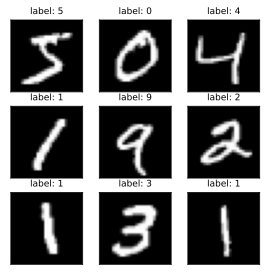

In [40]:
set_figsize((4.5,4.5))

show_img_grid(
    [data['train']['images'][i].reshape(28,28) for i in range(9)],
    [f"label: {data['train']['labels'][i].item()}" for i in range(9)],
)

# Process images

One needs to rescale images so the size of each image is a power of $2$. This is required for the algorithm to work and could be seen as a drawback. 

The are two options to rescale:
1. **Downscaling** the image may reduce the time required to train the tensor network model, but also has a drawback as it removes necessary information by reduction. 
2. **Upscaling** works in the opposit way. 
Which way to choose depends on a particular situation.

First, I determine the nearest powers of $2$ given the size of each image.

In [41]:
img_vec = data['train']['images'][0]  # take an image
size = jnp.sqrt(img_vec.size).astype(int)
size_l, size_h = power_of_two(size)   # returns nearest powers of 2 (low and high)

print(f'The nearest powers of two are: {size_l} and {size_h}.')

The nearest powers of two are: 16 and 32.


I decide to downscale the image to $16 \times 16$ pixels.

In [42]:
def resize(img_vec: jnp.ndarray, shape: Tuple[int,int]) -> jnp.ndarray:
    """
    Resizing the image vector.
    """
    orig_size = jnp.sqrt(img_vec.size).astype(int)
    img = img_vec.reshape(orig_size, orig_size)
    img = jax.image.resize(img, shape, method='linear')
    return img.reshape(-1,1)

In [43]:
new_shape = (16,16)

In [44]:
# vectorized version of the resise
vresize = jax.vmap(functools.partial(resize, shape=new_shape))

In [45]:
train_images = jnp.squeeze(vresize(data['train']['images']))
test_images = jnp.squeeze(vresize(data['test']['images']))

In [46]:
train_images.shape, test_images.shape

((60000, 256), (10000, 256))

Checking if data is scaled properly by plotting random digits...

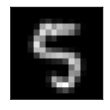

In [47]:
set_figsize((1.7,1.7))

j = 41312
show_img(train_images[j].reshape(new_shape))

# Feature map

The feature map $\Phi(\bf x)$ maps inpunt data vector $\bf x$ from a space of dimension $N$ to a space of dimension $d^N$, i.e. each component of the input vector $x_j$ is mapped into a $d$-dimensional vector. See Eq. 8 in text for details. We are interested in small $d$.

In [48]:
features = [
    lambda _: 1,
    lambda x: x,
    lambda x: x**2,
]

feature extraction...

In [49]:
train_data = jnp.stack([jax.vmap(jax.vmap(f))(train_images.T) for f in features])
test_data = jnp.stack([jax.vmap(jax.vmap(f))(test_images.T) for f in features])

In [50]:
train_data.shape, test_data.shape

((3, 256, 60000), (3, 256, 10000))

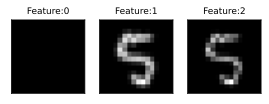

In [51]:
j = 41312     
img = train_data[:,:,j]

set_figsize((4.5,5.5))

_, axs = plt.subplots(1, len(features), sharey=True)
for i in range(len(features)):
    show_img(img[i,:].reshape(new_shape), 
             axs[i], 
             title=f'Feature:{i}')

## Normalizing features

In [52]:
def normalize_along_axis(a: jnp.ndarray, 
                         ord: Optional[int]=2,
                         axis: Optional[int]=0) -> jnp.ndarray:
    z_ = jnp.atleast_1d(jnp.linalg.norm(a, ord, axis))
    z = z_.at[jnp.where(z_==0.0)].set(1.0)
    return a / jnp.expand_dims(z, axis)

train_data = normalize_along_axis(train_data, axis=0)
test_data = normalize_along_axis(test_data, axis=0)

checking on random sample...

In [53]:
sample_size = 100

key = jax.random.PRNGKey(31415)
key1, key2 = jax.random.split(key, 2)

for i in range(sample_size):
    m = jax.random.choice(key1, train_data.shape[1]) # random feature
    n = jax.random.choice(key2, train_data.shape[2]) # random image
    assert jnp.allclose(train_data[:,m,n].T @ train_data[:,m,n], 1)
    assert jnp.allclose(test_data[:,m,n].T @ test_data[:,m,n], 1)

Checking again if images are correctly processed...

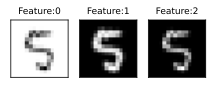

In [54]:
j = 41312     
img = train_data[:,:,j]

set_figsize((3.5,4.5))

_, axs = plt.subplots(1, len(features), sharey=True)
for i in range(len(features)):
    show_img(img[i,:].reshape(new_shape), 
             axs[i], 
             title=f'Feature:{i}',
            )

## Rearranging axis for convenience

Because JAX preferes leading axes, I rearrange the data axes.

In [55]:
train_data = train_data.transpose(1,0,2)
test_data = test_data.transpose(1,0,2)

In [56]:
train_data.shape, test_data.shape

((256, 3, 60000), (256, 3, 10000))

# Learning the Tree Tensor Network

## The reduced covariance matrix and a truncation point

In [57]:
@jax.jit
def suggest_truncation(
        A: jnp.ndarray, 
        tol: Optional[float]=1e-3
        ) -> Tuple[jnp.ndarray, jnp.ndarray, int]:
    """
    Suggest a truncation index of the spectrum 
    to approximate the input covariance matrix.
    The truncation point satisfies the condition:
    sum(p)/trace(a) < eps.

    Input:
    ------
    A:      Matrix to be truncated (must be Hermitian).
    tol:    The allowed truncation error.

    Output:
    -------
    p:      The spectrum (eigenvalues) in increasing order.
    U:      The corresponding eigenvectors.
    idx:    The suggested index corresponding to the tol.
    """
    p, U = jnp.linalg.eigh(A)
    err = jnp.cumsum(p / jnp.trace(A))
    idx = jnp.searchsorted(err, tol)
    return p, U, idx

quickly checking

In [58]:
A = rand_hermitian(100)

p, U, idx = suggest_truncation(A, tol=1e-6)
jnp.allclose((U[:,idx:] * p[idx:]) @ U[:,idx:].conj().T, A, atol=1e-5) 

DeviceArray(True, dtype=bool)

Also, checking the behavior of truncation on a set of cutoff points.

In [59]:
# random covariance matrix
A = rand_psd(100)

tols = [0.5**x for x in range(10)]
err = []
indices = []
for tol in tols:
    p,U,idx = suggest_truncation(A, tol=tol)
    Aᵟ = (U[:,idx:] * p[idx:]) @ U[:,idx:].conj().T
    Δ = jnp.abs(jnp.trace(A-Aᵟ))
    err.append(Δ)
    indices.append(idx)

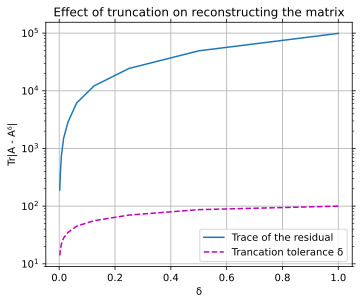

In [60]:
plot(tols, [err, indices], 
     xlabel='δ', ylabel='Tr|A - Aᵟ|', 
     legend=['Trace of the residual', 'Trancation tolerance δ'],
     figsize=(5.5,4.5),
     yscale='log',
     title='Effect of truncation on reconstructing the matrix'
)

## The protocol

To start, I introduce the tree data structure. This should accumulate the isometries as the algorithm keep building the tree recursively.

In [61]:
Tree = Union[jnp.ndarray, List[jnp.ndarray]]

In [62]:
@jax.jit
def project(tree: Tree, isoms: Tree, *other: Tree) -> Tree:
    """
    A projector of input tree onto the isometries.
    Tree is represented as a list/tuple of JAX arrays.
    """
    n = len(tree)
    idx = zip(*sliding_window(range(n), size=2, step=2))
    new_tree = jax.tree_multimap(
        lambda i,j,x: jnp.einsum(
            'mj,nj,mnk->kj', 
            tree[i], 
            tree[j], 
            x
        ),
        *idx, 
        isoms,
    )
    if other:
        return project(new_tree, *other)
    else:
        return new_tree

In [63]:
@jax.jit
def get_reduced_densities(tree: Tree, tol: Optional[float]=1e-3) -> Tree:
    """
    Calculate the reduced dencities.
    """
    # precomputes all density matrices
    rhos = jax.tree_map(
        lambda x: jnp.einsum('ij,kj->ikj', x, x.conj()),
        tree
    )

    # number of samples
    Z = tree[-1].shape[-1]

    # pairwise reduced covariance
    idx = zip(*sliding_window(range(len(tree)), size=2, step=2))
    rho_ij = jax.tree_multimap(
        lambda i,j: 1/Z * jnp.einsum(
            'ikj,mnj->imkn', 
            rhos[i], 
            rhos[j]
        ),
        *idx
    )
    return rho_ij

In [64]:
def truncate(A: jnp.ndarray, 
             max_bond: Optional[int]=200, 
             tol: Optional[float]=1e-3
             ) -> jnp.ndarray:
    """
    This is just a helper function to
    truncate the input tensor and reshape
    approprietely. Note, as I want to keep
    the heavy lifting in a jitted subroutine.
    The actual slicing is happening here.
    """
    m,n,*_ = A.shape
    C = A.reshape(m*n,-1)
    #if not ispsd(C):
    #    print('WARN: Matrix is not psd')
    #    C = get_nearest_psd(C)
    _,U,idx = suggest_truncation(C, tol)
    if idx == m*n:
        # nothing to cut
        result = U
    elif m*n - max_bond <= idx:
        # soft cut
        result = U[:,idx:]
    else:
        # hard cut
        result = U[:,-max_bond:]
    return result.reshape(m,n,-1)

In [65]:
def build_tree(tree: Tree, 
               tol: Optional[float]=1e-3,
               max_bond: Optional[int]=200,
               verbose: Optional[bool]=False
              ) -> Tree:

    # getting the tree size
    n = len(tree)

    if verbose:
        in_dim = jnp.array(jax.tree_map(lambda x: x.shape[0], tree))
        print(f'Tree width: {n}\tMax dimension: {in_dim.max().item()}')

    if n == 2:
        return

    assert is_power_of_two(n), 'The tree size must be a power of two'
        
    # calculate the reduced density matrices
    rho_ij = get_reduced_densities(tree, tol=tol)
       
    # truncated (approximated) isometries
    isoms = jax.tree_map(
        functools.partial(truncate, max_bond=max_bond, tol=tol), 
        rho_ij
    )
    yield isoms
    # defining a new tree
    new_tree = project(tree, isoms)
    yield from build_tree(new_tree, 
                          max_bond=max_bond, 
                          tol=tol, 
                          verbose=verbose)

In [66]:
# converting the ndarray to a list
phi_train = jax.tree_map(jnp.asarray, tuple(train_data))
phi_test = jax.tree_map(jnp.asarray, tuple(test_data))

The maximum bond dimension can improve the accuracy, but also increases the dimensionality of the dataset used for the downstream classification.

In [67]:
tree_iterator = build_tree(phi_train, max_bond=300, tol=3e-2, verbose=True)
tree_iterator1, tree_iterator2 = itertools.tee(tree_iterator, 2)

Below is the training...

In [68]:
tic = timer()
train_ = project(phi_train, *tree_iterator1)
toc = timer()
exec_time(tic,toc)

Tree width: 256	Max dimension: 3
Tree width: 128	Max dimension: 3
Tree width: 64	Max dimension: 4
Tree width: 32	Max dimension: 4
Tree width: 16	Max dimension: 8
Tree width: 8	Max dimension: 25
Tree width: 4	Max dimension: 157
Tree width: 2	Max dimension: 227
Execution Time: 00:00:44:43.9165


In [69]:
# test data projection
test_ = project(phi_test, *tree_iterator2)

In [70]:
jax.tree_map(jnp.shape, train_), jax.tree_map(jnp.shape, test_)

(((205, 60000), (227, 60000)), ((205, 10000), (227, 10000)))

# Classifying digits

## Preparing the data

In [71]:
X_train = jnp.vstack(train_).T
X_test = jnp.vstack(test_).T

y_train = jnp.squeeze(data['train']['labels'])
y_test = jnp.squeeze(data['test']['labels'])

In [72]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 432), (10000, 432), (60000,), (10000,))

## The conjugate gradient algorithm implementation

I want to follow the paper as close as possible (and also learn something along the line). So, I have decided to implement a custom conjugate gradient descent algorithm that the paper is using as well.

In [73]:
class Params(NamedTuple):
    x: jnp.ndarray
    r: jnp.ndarray
    d: jnp.ndarray

@jax.jit
def update(A: jnp.ndarray, params: Params) -> Params:    
    x,r,d = params    
    r2 = r.conj().T @ r
    Ad = A @ d
    alpha = r2 / (d.conj().T @ Ad)
    x = x + (alpha * d)
    r = r + (alpha * Ad)
    beta = (r.conj().T @ r) / r2
    d = -r + (beta * d)
    return Params(x, r, d)

def init(A, b):
    x = jnp.ones_like(b)
    r = (A @ x) - b
    d = -r
    return Params(x, r, d)
    
def conjugate_gradient(A, b, max_steps=int(1e+5), tol=1e-6):
    params = init(A,b)
    step = 0
    while step < max_steps:
        norm = jnp.linalg.norm(params.r)
        if norm < 1e-4:
            break
        params = update(A, params)
        step += 1
    return params.x

Testing it on a randomly generated dataset.

In [74]:
key = jax.random.PRNGKey(31415)
key1, key2 = jax.random.split(key, 2)

n = 100
A = rand_psd(n)
b = jax.random.normal(key1, (n,1)) +\
    1j * jax.random.normal(key2, (n,1))

In [75]:
x = conjugate_gradient(A, b)
jnp.allclose(A @ x, b, atol=1e-2)

DeviceArray(True, dtype=bool)

## Train a OvA classifier using CGD

In [76]:
@jax.jit
def _prep(X, y):
    """
    Prepare the data for CG classifier.
    Appends a unit vector of bias and
    creates input matrices representing
    the square loss.
    """
    m,_ = X.shape
    # adding bias term
    I = jnp.ones(shape=(m,1), dtype=jnp.float32)
    X_ = jnp.hstack([I, X])
    Z = X_.T @ X_
    q = X_.T @ y
    return Z, q

def train_binary_clf(X,y):
    assert jnp.unique(y).size == 2, 'Got multiple class labels'
    w = conjugate_gradient(*_prep(X, y))
    return w

In [77]:
def clf_build(X, y):
    """
    Train a OvA classifier.
    """
    # assumed number of digits in the dataset
    n_digits = 10   
    # storing weights
    W = []
    # optimize the weights for each digit
    for i in jnp.arange(n_digits):
        w = train_binary_clf(X, y[:,i])
        W.append(w)
    # returns a set of parameters n_classes x n_features
    return jnp.stack(W)

In [78]:
y_train_one_hot = jax.nn.one_hot(y_train, num_classes=10)
W = clf_build(X_train, y_train_one_hot)

In [79]:
def clf_predict(W, X):
    # resizing the arrray if one sample provided
    if X.ndim == 1:
        X = X[jnp.newaxis,:]
    # getting the shape
    m,n = X.shape
    # the number of digits in the dataset
    n_digits = W.shape[0]
    # adding bias term
    I = jnp.ones(shape=(m,1), dtype=jnp.float32)
    X_ = jnp.hstack([I, X])
    # stores predictions
    Y = []
    for digit in jnp.arange(n_digits):
        y = X_ @ W[digit,:]
        Y.append(y)
    return jnp.argmax(jnp.stack(Y), axis=0)

In [80]:
y_pred = clf_predict(W, X_test)

and for tthe single sample

In [81]:
clf_predict(W, X_test[0,:])

DeviceArray([7], dtype=int32)

We can now also check a single sample...

In [82]:
print(f'Classification report for OvA classifier CG:\n\n'
      f'{metrics.classification_report(y_test, y_pred)}\n')

Classification report for OvA classifier CG:

              precision    recall  f1-score   support

           0       0.84      0.98      0.91       980
           1       0.97      0.99      0.98      1135
           2       0.93      0.92      0.93      1032
           3       0.94      0.93      0.93      1010
           4       0.96      0.93      0.94       982
           5       0.94      0.93      0.93       892
           6       0.95      0.93      0.94       958
           7       0.93      0.93      0.93      1028
           8       0.96      0.92      0.94       974
           9       0.94      0.89      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.93      0.94     10000
weighted avg       0.94      0.94      0.94     10000




In [83]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

Classification confusion matrix:

[[ 960    0    2    0    0    5    8    1    4    0]
 [   0 1122    8    2    0    0    1    0    2    0]
 [  26    1  949   19    4    1    8   16    6    2]
 [  15    2   15  937    0   13    1   16    7    4]
 [  17    0    4    0  914    2    8    4    4   29]
 [  20    3    4   18    1  827    8    4    4    3]
 [  34    3   10    1    5    8  889    1    7    0]
 [   8   13   14    6    5    0    0  961    3   18]
 [  27    0    6    8    6   13    9    7  893    5]
 [  34    7    6    5   18   10    2   20    4  903]]



## Training on the original data

In [84]:
X_train_orig = train_images
X_test_orig = test_images

In [85]:
W = clf_build(X_train_orig, y_train_one_hot)
y_pred = clf_predict(W, X_test_orig)

In [86]:
print(f'Classification report for OvA classifier CG:\n\n'
      f'{metrics.classification_report(y_test, y_pred)}\n')

Classification report for OvA classifier CG:

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       980
           1       0.81      0.98      0.89      1135
           2       0.92      0.79      0.85      1032
           3       0.85      0.87      0.86      1010
           4       0.83      0.89      0.86       982
           5       0.89      0.74      0.81       892
           6       0.89      0.92      0.90       958
           7       0.86      0.86      0.86      1028
           8       0.86      0.78      0.82       974
           9       0.84      0.81      0.82      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000




In [87]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

Classification confusion matrix:

[[ 947    0    2    1    1    9   11    2    6    1]
 [   0 1109    2    2    2    2    5    1   12    0]
 [  18   63  811   24   16    1   39   21   34    5]
 [   8   22   19  882    4   13    9   21   22   10]
 [   1   24    7    0  877    3    8    2    9   51]
 [  22   13    4   74   24  662   25   15   33   20]
 [  19   11    9    0   19   14  882    0    4    0]
 [   5   48   14    5   25    0    1  879    1   50]
 [  13   57    8   30   22   37   15   10  759   23]
 [  16   14    4   16   67    2    1   71    5  813]]

